# MathematicalProgram Tutorial
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


## Background
Many engineering problems can be formulated as mathematical optimization problems, and solved by numerical solvers. A generic mathematical optimization problem can be formulated as
$\begin{aligned}
\begin{array}{rl}
                       \min_x \;  &  f(x)
   \\\text{subject to}  \;  &  x \in\mathcal{S}
   \end{array}
   \qquad
   \boxed{
         \begin{array}{ll}
      \text{The real-valued decision variable is}       &x\\
      \text{The real-valued cost function is}           &f(x)\\
      \text{The constraint set is}                      &\mathcal{S}\\
      \text{The optimal } x \text{ that minimizes the cost function is}  &x^*
      \end{array}
      }
\end{aligned}$

where $x$ is the real-valued decision variable(s), $f(x)$ is the real-valued *cost function*, $\mathcal{S}$ is the constraint set for $x$. Our goal is to find the optimal $x^*$ within the constraint set $\mathcal{S}$, such that $x^*$ minimizes the cost function $f(x)$.

For example, the following optimization problem determines the value of $x$ 
that minimizes $x^3 + 2x + 1$ subject to $x \ge 1$.
$\begin{aligned}
\begin{array}{rl}
\min_x\;&x^3 + 2x + 1\\
\text{subject to}\;\;&x \ge 1
\end{array}
\quad
\boxed{
      \begin{array}{ll}
          \text{The real-valued decision variable is}         &  x\\
          \text{The real-valued cost function }f(x) \text{ is} &  x^3 + 2x + 1\\
          \text{The set }\mathcal{S} \text{ of constraints is}      &  x \ge 1\\
          \text{The value that minimizes the cost function is}    &  x^* = 1
   \end{array}
}
\end{aligned}$

In general, how an optimization problem is solved depends on its categorization (categories include Linear Programming, Quadratic Programming, Mixed-integer Programming, etc.). Categorization depends on properties of both the cost function $f(x)$ and the constraint set $\mathcal{S}$. For example, if the cost function $f(x)$ is a linear function of $x$, and the constraint $\mathcal{S}$ is a linear set $\mathcal{S} = \{x | Ax\le b\}$, then we have a *linear programming* problem, which is efficiently solved with certain solvers. 

There are multiple solvers for each category of optimization problems,
but each solver has its own API and data structures.
Frequently, users need to rewrite code when they switch solvers.
To remedy this, Drake provides a common API through the *MathematicalProgram* class.
In addition to avoiding solver-specific code,
the constraint and cost functions can be written in symbolic form (which makes code more readable).
In these ways, Drake's MathematicalProgram is akin to [YALMIP](https://yalmip.github.io/) in MATLAB or [JuMP](https://github.com/JuliaOpt/JuMP.jl) in Julia, and we support both Python and C++.
<br> Note: Drake supports many [solvers](https://drake.mit.edu/doxygen_cxx/group__solvers.html)
(some are open-source and some require a license).

Drake can formulate and solve the following categories of optimization problems
* Linear programming
* Quadratic programming
* Second-order cone programming
* Nonlinear nonconvex programming
* Semidefinite programming
* Sum-of-squares programming
* Mixed-integer programming (mixed-integer linear programming, mixed-integer quadratic programming, mixed-integer second-order cone programming).
* Linear complementarity problem

This tutorial provides the basics of Drake's MathematicalProgram.
Advanced tutorials are available at the [bottom](#Advanced-tutorials) of this document.


## Basics of MathematicalProgram class
Drake's MathematicalProgram class contains the mathematical formulation of an optimization problem, namely the decision variables $x$, the cost function $f(x)$, and the constraint set $\mathcal{S}$.

### Initialize a MathematicalProgram object

 To initialize this class, first create an empty MathematicalProgram as

In [ ]:
from pydrake.solvers import MathematicalProgram
import numpy as np
import matplotlib.pyplot as plt

# Create an empty MathematicalProgram named prog (with no decision variables, 
# constraints or cost function)
prog = MathematicalProgram()



### Adding decision variables
Shown below, the function `NewContinuousVariables` adds two new continuous decision variables to `prog`.  The newly added variables are returned as `x` in a numpy array. 
<br><font size=-1> Note the range of the variable is a continuous set, as opposed to binary variables which only take discrete value 0 or 1.</font>

In [ ]:
x = prog.NewContinuousVariables(2)


The default names of the variable in *x* are "x(0)" and "x(1)".  The next line prints the default names and types in `x`, whereas the second line prints the symbolic expression "1 + 2x[0] + 3x[1] + 4x[1]".

In [ ]:
print(x)
print(1 + 2*x[0] + 3*x[1] + 4*x[1])

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]
(1 + 2 * x(0) + 7 * x(1))


To create an array `y` of two variables named "dog(0)"" and "dog(1)", pass the name "dog" as a second argument to `NewContinuousVariables()`. Also shown below is the printout of the two variables in `y` and a symbolic expression involving `y`.

In [ ]:
y = prog.NewContinuousVariables(2, "dog")
print(y)
print(y[0] + y[0] + y[1] * y[1] * y[1])

[Variable('dog(0)', Continuous) Variable('dog(1)', Continuous)]
(2 * dog(0) + pow(dog(1), 3))


To create a $3 \times 2$ matrix of variables named "A", type 

In [ ]:
var_matrix = prog.NewContinuousVariables(3, 2, "A")
print(var_matrix)

[[Variable('A(0,0)', Continuous) Variable('A(0,1)', Continuous)]
 [Variable('A(1,0)', Continuous) Variable('A(1,1)', Continuous)]
 [Variable('A(2,0)', Continuous) Variable('A(2,1)', Continuous)]]


### Adding constraints
There are many ways to impose constraints on the decision variables. This tutorial shows a few simple examples. Refer to the links at the [bottom](#Advanced-tutorials) of this document for other types of constraints.



#### AddConstraint
The simplest way to add a constraint is with `MathematicalProgram.AddConstraint()`.

In [ ]:
# Add the constraint x(0) * x(1) = 1 to prog
prog.AddConstraint(x[0] * x[1] == 1)


You can also add inequality constraints to `prog` such as

In [ ]:
prog.AddConstraint(x[0] >= 0)
prog.AddConstraint(x[0] - x[1] <= 0)

`prog` automatically analyzes these symbolic inequality constraint expressions and determines they are all *linear* constraints on $x$.

### Adding Cost functions
In a complicated optimization problem, it is often convenient to write the total cost function $f(x)$ as a sum of individual cost functions

$\begin{aligned}
f(x) = \sum_i g_i(x)
\end{aligned}$


#### AddCost method.
The simplest way to add an individual cost function $g_i(x)$ to the total cost function $f(x)$ is with the `MathematicalProgram.AddCost()` method (as shown below).

In [ ]:
# Add a cost x(0)**2 + 3 to the total cost. Since prog doesn't have a cost before, now the total cost is x(0)**2 + 3
prog.AddCost(x[0] ** 2 + 3)

To add another individual cost function $x(0) + x(1)$ to the total cost function $f(x)$, simply call `AddCost()` again as follows

In [ ]:
prog.AddCost(x[0] + x[1])

now the total cost function becomes $x(0)^2 + x(0) + x(1) + 3$.

`prog` can analyze each of these individual cost functions and determine that $x(0) ^ 2 + 3$  is a convex quadratic function, and $x(0) + x(1)$ is a linear function of $x$.

You can render your program in LaTeX at any time:

In [ ]:
from IPython.display import display, Markdown
display(Markdown(prog.ToLatex()))

\begin{align*}
\min_{x_{0}, x_{1}, dog_{0}, dog_{1}, A_{0,0}, A_{1,0}, A_{2,0}, A_{0,1}, A_{1,1}, A_{2,1}} \quad & (x_{0} + x_{1})\\
 &  + (3 + x_{0}^{2})\\
 \text{subject to}\quad & \begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix}^T \begin{bmatrix} 0 & 0.500 \\ 0.500 & 0 \end{bmatrix} \begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix} = 1,\\
 & (x_{0} - x_{1}) \le 0,\\
 & -0 \le x_{0}.\\
\end{align*}


### Solve the optimization problem
Once all the decision variables/constraints/costs are added to `prog`, we are ready to solve the optimization problem.



#### Automatically choosing a solver
The simplest way to solve the optimization problem is to call `Solve()` function. Drake's MathematicalProgram analyzes the type of the constraints/costs, and then calls an appropriate solver for your problem. The result of calling `Solve()` is stored inside the return argument. Here is a code snippet

In [ ]:
"""
Solves a simple optimization problem
       min x(0)^2 + x(1)^2
subject to x(0) + x(1) = 1
           x(0) <= x(1)
"""
from pydrake.solvers import Solve
# Set up the optimization problem.
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] + x[1] == 1)
prog.AddConstraint(x[0] <= x[1])
prog.AddCost(x[0] **2 + x[1] ** 2)

# Now solve the optimization problem.
result = Solve(prog)

# print out the result.
print("Success? ", result.is_success())
# Print the solution to the decision variables.
print('x* = ', result.GetSolution(x))
# Print the optimal cost.
print('optimal cost = ', result.get_optimal_cost())
# Print the name of the solver that was called.
print('solver is: ', result.get_solver_id().name())

Success?  True
x* =  [0.4999745 0.5000255]
optimal cost =  0.5000000013010027
solver is:  Clarabel


Notice that we can then retrieve optimization result from the return argument of `Solve`. For example, the solution $x^*$ is retrieved from `result.GetSolution()`, and the optimal cost from `result.get_optimal_cost()`.

Some optimization solution is infeasible (doesn't have a solution). For example in the following code example, `result.get_solution_result()` will not report `kSolutionFound`.

In [ ]:
"""
An infeasible optimization problem.
"""
prog = MathematicalProgram()
x = prog.NewContinuousVariables(1)[0]
y = prog.NewContinuousVariables(1)[0]
prog.AddConstraint(x + y >= 1)
prog.AddConstraint(x + y <= 0)
prog.AddCost(x)

result = Solve(prog)
print("Success? ", result.is_success())
print(result.get_solution_result())

Success?  False
SolutionResult.kInfeasibleConstraints


#### Manually choosing a solver

If you want to choose a solver yourself, rather than Drake choosing one for you, you could instantiate a solver explicitly, and call its `Solve` function. There are two approaches to instantiate a solver. For example, if I want to solve a problem using the open-source solver [IPOPT](https://github.com/coin-or/Ipopt), I can instantiate the solver using either of the two approaches:
1. The simplest approach is to call `solver = IpoptSolver()`
2. The second approach is to construct a solver with a given solver ID as `solver = MakeSolver(IpoptSolver().solver_id())`

In [ ]:
"""
Demo on manually choosing a solver
Solves the problem
min x(0)
s.t x(0) + x(1) = 1
    0 <= x(1) <= 1
"""
from pydrake.solvers import IpoptSolver
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] + x[1] == 1)
prog.AddConstraint(0 <= x[1])
prog.AddConstraint(x[1] <= 1)
prog.AddCost(x[0])

# Choose IPOPT as the solver.
# First instantiate an IPOPT solver.

solver = IpoptSolver()
# The initial guess is [1, 1]. The third argument is the options for Ipopt solver,
# and we set no solver options.
result = solver.Solve(prog, np.array([1, 1]), None)

print(result.get_solution_result())
print("x* = ", result.GetSolution(x))
print("Solver is ", result.get_solver_id().name())
print("Ipopt solver status: ", result.get_solver_details().status,
      ", meaning ", result.get_solver_details().ConvertStatusToString())


SolutionResult.kSolutionFound
x* =  [-9.49998992e-11  1.00000000e+00]
Solver is  IPOPT
Ipopt solver status:  0 , meaning  Success


Note that `solver.Solve()` expects three input arguments, the optimization program `prog`, the initial guess of the decision variable values (`[1, 1]` in this case), and an optional setting for the solver (`None` in this case, we use the default IPOPT setting). If you don't have an initial guess, you could call `solver.Solve(prog)`. Drake will choose a default initial guess (a 0-valued vector), but this initial guess might be a bad starting point for optimization. Note from the following example code, with the default initial guess, the solver cannot find a solution, even though a solution exists (and could be found with initial guess [1, 1]).

In [ ]:
from pydrake.solvers import MakeSolver
solver = MakeSolver(IpoptSolver().solver_id())
result = solver.Solve(prog)
print(result.get_solution_result())
print("x* = ", result.GetSolution(x))

SolutionResult.kSolutionFound
x* =  [-9.50000206e-11  1.00000000e+00]


Also note that if we know which solver is called, then we can access some solver-specific result, by calling `result.get_solver_details()`. For example, `IpoptSolverDetails` contains a field `status`, namely the status code of the IPOPT solver, we could access this info by

In [ ]:
print("Ipopt solver status: ", result.get_solver_details().status,
      ", meaning ", result.get_solver_details().ConvertStatusToString())

Ipopt solver status:  0 , meaning  Success


Each solver has its own details. You should refer to `FooSolverDetails` class on what is stored inside the return argument of `result.get_solver_details()`. For example, if you know that IPOPT is called, then refer to `IpoptSolverDetails` class; for OSQP solver, refer to `OsqpSolverDetails`, etc.

### Using an initial guess
Some optimization problems, such as nonlinear optimization, require an initial guess. Other types of problems, such as quadratic programming, mixed-integer optimization, etc,  can be solved faster if a good initial guess is provided. The user could provide an initial guess as an input argument in `Solve` function. If no initial guess is provided, Drake will use a zero-valued vector as the initial guess.

In the example below, we show that an initial guess could affect the result of the problem. Without an user-provided initial guess, the solver might be unable to find the solution.

In [ ]:
from pydrake.solvers import IpoptSolver
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0]**2 + x[1]**2 == 100.)
prog.AddCost(x[0]**2-x[1]**2)
solver = IpoptSolver()
# The user doesn't provide an initial guess.
result = solver.Solve(prog, None, None)
print(f"Without a good initial guess, the result is {result.is_success()}")
print(f"solution {result.GetSolution(x)}")
# Pass an initial guess
result = solver.Solve(prog, [-5., 0.], None)
print(f"With a good initial guess, the result is {result.is_success()}")
print(f"solution {result.GetSolution(x)}")

Without a good initial guess, the result is False
solution [0. 0.]
With a good initial guess, the result is True
solution [-10.   0.]


For more details on setting the initial guess, the user could refer to [Nonlinear program](./nonlinear_program.ipynb) section `Setting the initial guess`.


## Add callback
Some solvers support adding a callback function in each iteration. One usage of the callback is to visualize the solver progress in the current iteration. `MathematicalProgram` supports this usage through the function `AddVisualizationCallback`, although the usage is not limited to just visualization, the callback function can do anything. Here is an example

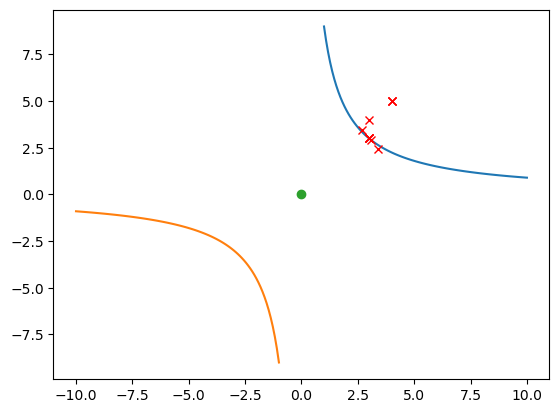

In [ ]:
# Visualize the solver progress in each iteration through a callback
# Find the closest point on a curve to a desired point.

fig = plt.figure()
curve_x = np.linspace(1, 10, 100)
ax = plt.gca()
ax.plot(curve_x, 9./curve_x)
ax.plot(-curve_x, -9./curve_x)
ax.plot(0, 0, 'o')
x_init = [4., 5.]
ax.plot(x_init[0], x_init[1], 'x', color='red')

def update(x):
    ax.plot(x[0], x[1], 'x', color='red')
    
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(update, x)
result = Solve(prog, x_init)

## Advanced tutorials
[Setting solver parameters](./solver_parameters.ipynb)

[Updating costs and constraints (e.g. for efficient solving of many similar programs)](./updating_costs_and_constraints.ipynb)

[Debugging tips](./debug_mathematical_program.ipynb)

[Linear program](./linear_program.ipynb)

[Quadratic program](./quadratic_program.ipynb)

[Nonlinear program](./nonlinear_program.ipynb)

[Sum-of-squares optimization](./sum_of_squares_optimization.ipynb)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daec9c67-c271-4556-b3d6-020f0178ac09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>